In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-SEMICONDUCTOR-ORG-TYPES"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [4]:
org_types_dataset = load_dataset(
    "ought/raft", 
    name="semiconductor_org_types" , 
    cache_dir= "/Data/pedro.silva"
)

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/449 [00:00<?, ? examples/s]

In [5]:
train_dataset = org_types_dataset['train'].add_column(
    "labels",
    list(map(lambda x: x- 1, org_types_dataset['train']['Label']))
)

test_dataset = org_types_dataset['test'].add_column(
    "labels",
    list(map(lambda x: x- 1, org_types_dataset['test']['Label']))
)

In [6]:
classes = np.unique(train_dataset['labels'], return_counts=True)
classes

(array([0, 1, 2]), array([38,  6,  6]))

In [7]:
num_classes = len(classes[0])
num_classes

3

In [8]:
train_dataset

Dataset({
    features: ['Paper title', 'Organization name', 'ID', 'Label', 'labels'],
    num_rows: 50
})

In [9]:
classes_names = ["comapny", "research institute", "university"]

In [16]:
train_size = 0.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = []

    for i in range(len(dataset['labels'])):
        label = dataset['labels'][i]
        text = dataset['Organization name'][i] + dataset['Paper title'][i] 
        indexes_dict[label].append(text)


    train_data = {
        'labels': [],
        'text': []
    }

    validation_data = {
        "labels" : [],
        "text": []
    }

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])
        size = int(train_size * n)

        train_data['text'] += indexes_dict[label][:size]
        train_data['labels'] += [label]*size
        
        validation_data['text'] +=indexes_dict[label][size:]
        validation_data['labels'] += [label]* (n-size)

    return train_data, validation_data

In [17]:
train, val = stratified_train_test_split(
    train_dataset, 
    classes,
    0.6
)

In [18]:
np.bincount(train['labels']), np.bincount(val['labels'])

(array([22,  3,  3]), array([16,  3,  3]))

## Train model

In [20]:
class_counts = np.bincount(
    train['labels'],
)

alpha = len(train['labels'])/class_counts

In [21]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [27]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "FacebookAI/roberta-large", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['labels'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
    shuffle = True
)


val_dataloader = get_dataloader(
    val['text'],
    val['labels'],
    tokenizer,
    n_shots = 100,
    num_classes=num_classes,
    equalize_class=False
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= multiclass_f1_score,
    n_epochs=15
)


f1: 0.5909090638160706
tensor([[13,  0,  3],
        [ 3,  0,  0],
        [ 3,  0,  0]], device='cuda:0')


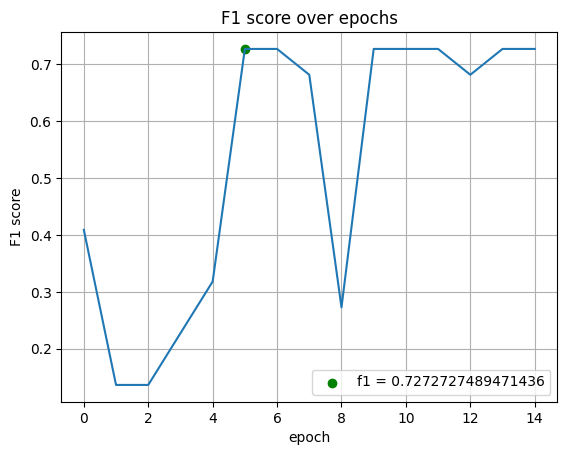

In [25]:
plt.plot(history['val_f1'])
plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-SEMICONDUCTOR-ORG-TYPES')

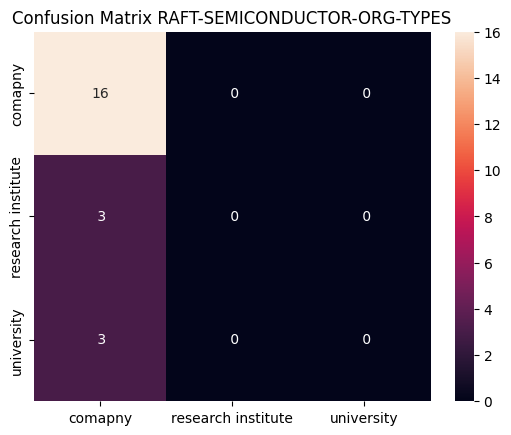

In [26]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name}")